<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

## Прогнозирование стоимости автомобиля по характеристикам
*Этот Ноутбук является Примером/Шаблоном (Baseline) к этому соревнованию и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.


> **baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline является хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

Помним, что по условию соревнования, нам нужно самостоятельно собрать обучающий датасет. В этом ноутбуке мы не будем рассматривать сбор данных. Предположим, что мы уже все собрали и просто подключили свой датасет через "Add Data", чтобы приступить к самому ML.

In [172]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder


In [173]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5


In [174]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [175]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [176]:
# отключаем предупреждения
import warnings
warnings.filterwarnings("ignore")

In [177]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [178]:
# включаем максимальное отображение колонок датасета
pd.set_option('display.max_columns', None)

# Setup

In [179]:
VERSION    = 16
DIR_TRAIN  = '../input/parsing-all-moscow-auto-ru-09-09-2020/' # подключил к ноутбуку внешний датасет
DIR_TEST   = '../input/sf-dst-car-price-prediction/'
VAL_SIZE   = 0.20   # 20%

# Data

In [180]:
!ls '../input'

parsing-all-moscow-auto-ru-09-09-2020  sf-dst-car-price-prediction


In [181]:
train = pd.read_csv(DIR_TRAIN+'all_auto_ru_09_09_2020.csv') # датасет для обучения модели
test = pd.read_csv(DIR_TEST+'test.csv')
sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')

In [182]:
train.head(5)

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,mileage,Комплектация,Привод,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,start_date,hidden,model
0,Седан,AUDI,040001,бензин,1990.0,2.8 MT (174 л.с.) 4WD,4.0,1991,SEDAN MECHANICAL 2.8,MECHANICAL,2.8,174.0,"Машина в приличном состоянии ,не гнилая не р...",350000,{'id': '0'},полный,LEFT,NaN,3.0,ORIGINAL,True,NaN,200000.0,2019-10-03T08:09:11Z,NaN,100
1,Седан,AUDI,EE1D19,бензин,1982.0,1.8 MT (90 л.с.),4.0,1986,SEDAN MECHANICAL 1.8,MECHANICAL,1.8,90.0,Машина в оригинале не гнилая все вопросы по те...,173424,{'id': '0'},передний,LEFT,NaN,3.0,ORIGINAL,True,NaN,60000.0,2020-09-06T06:49:40Z,NaN,100
2,Универсал 5 дв.,AUDI,0000CC,бензин,1988.0,2.3 MT (136 л.с.) 4WD,5.0,1989,WAGON_5_DOORS MECHANICAL 2.3,MECHANICAL,2.3,136.0,ПТС Оригинал!\nПолный комплект ключей!\nПо рез...,230000,{'id': '0'},полный,LEFT,NaN,3.0,ORIGINAL,True,NaN,99000.0,2020-09-02T14:04:21Z,NaN,100
3,Седан,AUDI,CACECB,бензин,1988.0,1.8 MT (90 л.с.),4.0,1989,SEDAN MECHANICAL 1.8,MECHANICAL,1.8,90.0,NaN,240000,{'id': '0'},передний,LEFT,NaN,3.0,ORIGINAL,True,NaN,65000.0,2020-08-23T17:40:09Z,NaN,100
4,Седан,AUDI,040001,бензин,1990.0,2.0 MT (101 л.с.),4.0,1991,SEDAN MECHANICAL 2.0,MECHANICAL,2.0,101.0,"Машина не гнилая, дыр нет, днище целое, даже в...",300000,{'id': '0'},передний,LEFT,NaN,3.0,DUPLICATE,True,NaN,100000.0,2020-09-08T09:22:07Z,NaN,100


In [183]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89378 entries, 0 to 89377
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              89377 non-null  object 
 1   brand                 89378 non-null  object 
 2   color                 89378 non-null  object 
 3   fuelType              89378 non-null  object 
 4   modelDate             89377 non-null  float64
 5   name                  89377 non-null  object 
 6   numberOfDoors         89377 non-null  float64
 7   productionDate        89378 non-null  int64  
 8   vehicleConfiguration  89377 non-null  object 
 9   vehicleTransmission   89377 non-null  object 
 10  engineDisplacement    89377 non-null  object 
 11  enginePower           89377 non-null  float64
 12  description           86124 non-null  object 
 13  mileage               89378 non-null  int64  
 14  Комплектация          89378 non-null  object 
 15  Привод             

In [184]:
test.head(5)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,74000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.2 AMT (105 л.с.),5,1603226273,RUB,2014,1100575026,"{""id"":""10373605"",""displacement"":1197,""engine_t...",LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,60563,2017,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.6 MT (110 л.с.),5,1603226277,RUB,2017,1100549428,"{""id"":""20913311"",""displacement"":1598,""engine_t...",LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,88000,2013,"{""code"":""SUPERB"",""name"":""Superb"",""ru_name"":""Су...",SUPERB,DSG 1.8 AMT (152 л.с.),5,1603226280,RUB,2014,1100658222,"{""id"":""20026323"",""nameplate"":""DSG"",""displaceme...",LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,95000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.6 AT (110 л.с.),5,1603226284,RUB,2014,1100937408,"{""id"":""20105521"",""displacement"":1598,""engine_t...",LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,58536,2008,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.8 AT (152 л.с.),5,1603226288,RUB,2012,1101037972,"{""id"":""4561004"",""displacement"":1798,""engine_ty...",LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [185]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

Посмотрим детальнее на test. Для быстрого анализа воспользуемся библиотекой pandas_profiling и построим интерактивный отчет

In [186]:
from pandas_profiling import ProfileReport

profile = ProfileReport(test, title="Pandas Profiling Report", minimal=True)
profile

In [187]:
# выведем отчет в отдельный html для удобного изучения

profile.to_file("test_report.html")

По отчету видим, что тестовый датасет содержит 32 столбца и 34 686 строк. Довольно много пропущенных значений - 60 956 пропусков. 
В датасете представлены данные трех типов: текстовые, числовые и ссылки (что по сути тоже текст). Видим, что данные в основном представлены в текстовом виде. Много переменных с уникальными значениями (HIGH CARDINALITY)  - 11. 

Данные по id представлены в столбце sell_id.

По дате выпуска автомобилей видим, что преобладает диапазон года выпуска с 2007 по 2017, остальные года выпуска встречаются реже

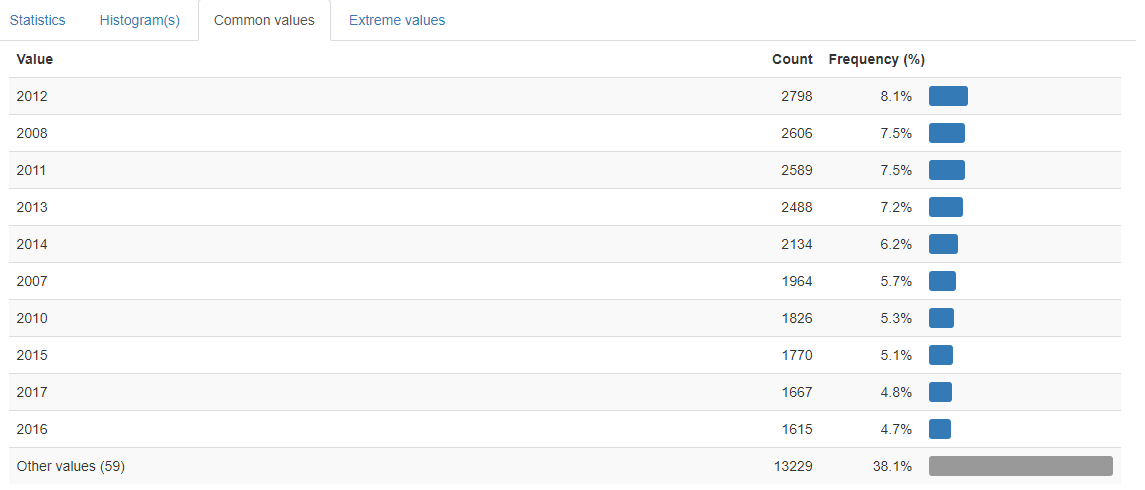

Судя по статистике, данные собраны в период с 19.10.2020 по 26.10.2020

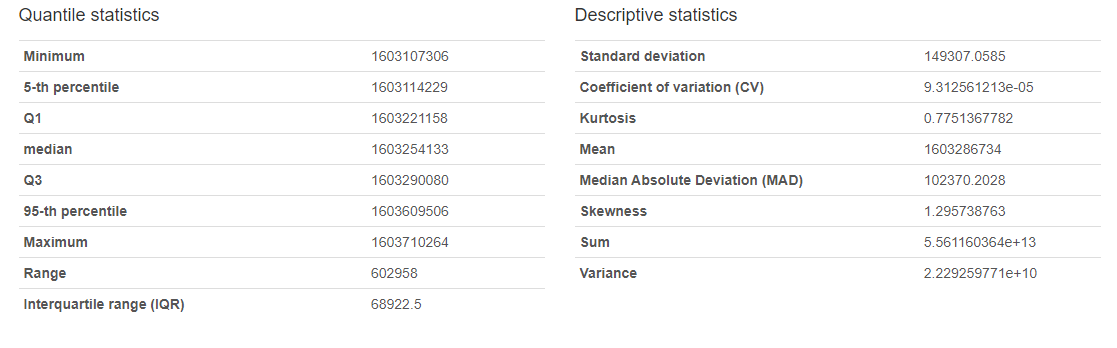

In [188]:
test['priceCurrency']

0        RUB
1        RUB
2        RUB
3        RUB
4        RUB
        ... 
34681    RUB
34682    RUB
34683    RUB
34684    RUB
34685    RUB
Name: priceCurrency, Length: 34686, dtype: object

В данных можно выделить топ-10 марок автомобилей

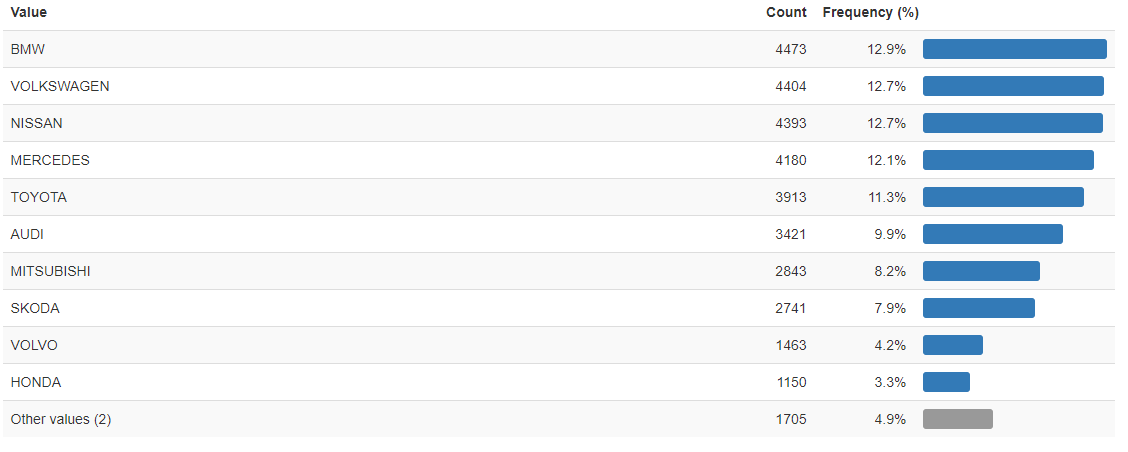

In [189]:
# полный список представленных марок:

test['brand'].value_counts()

BMW           4473
VOLKSWAGEN    4404
NISSAN        4393
MERCEDES      4180
TOYOTA        3913
AUDI          3421
MITSUBISHI    2843
SKODA         2741
VOLVO         1463
HONDA         1150
INFINITI       871
LEXUS          834
Name: brand, dtype: int64

Самые распространенные марки - это BMW, VOLKSWAGEN и NISSAN.

Наиболее важные данные, которые можно выделить для обучения, являются bodyType, brand, color, engineDisplacement, enginePower, fuelType, mileage, modelDate, numberOfDoors, vehicleTransmission, vendor, Владельцы, ПТС, Привод, Руль, name(л.с.).

Посмотрим подробнее на данные train

In [190]:
profile_train = ProfileReport(train, title="Pandas Profiling Report", minimal=True)
profile_train

In [191]:
# выведем отчет в отдельный html для удобного изучения

profile_train.to_file("train_report.html")

In [192]:
print(test.shape)
print(train.shape)

(34686, 32)
(89378, 26)


В тестовом датафрейме содержится на 6 столбцов больше, чем в теренировочном

В трэйне есть:
* 2114 дубликатов строк.
* 9 High cardinality столбцов, в отличие от теста. где таких столбцов 11
* 5 столбцов с пропущенными значениями
* Есть два столбца с неподдерживаемым типом, проверьте, нуждается ли он в очистке или дополнительном анализе: Состояние и hidden

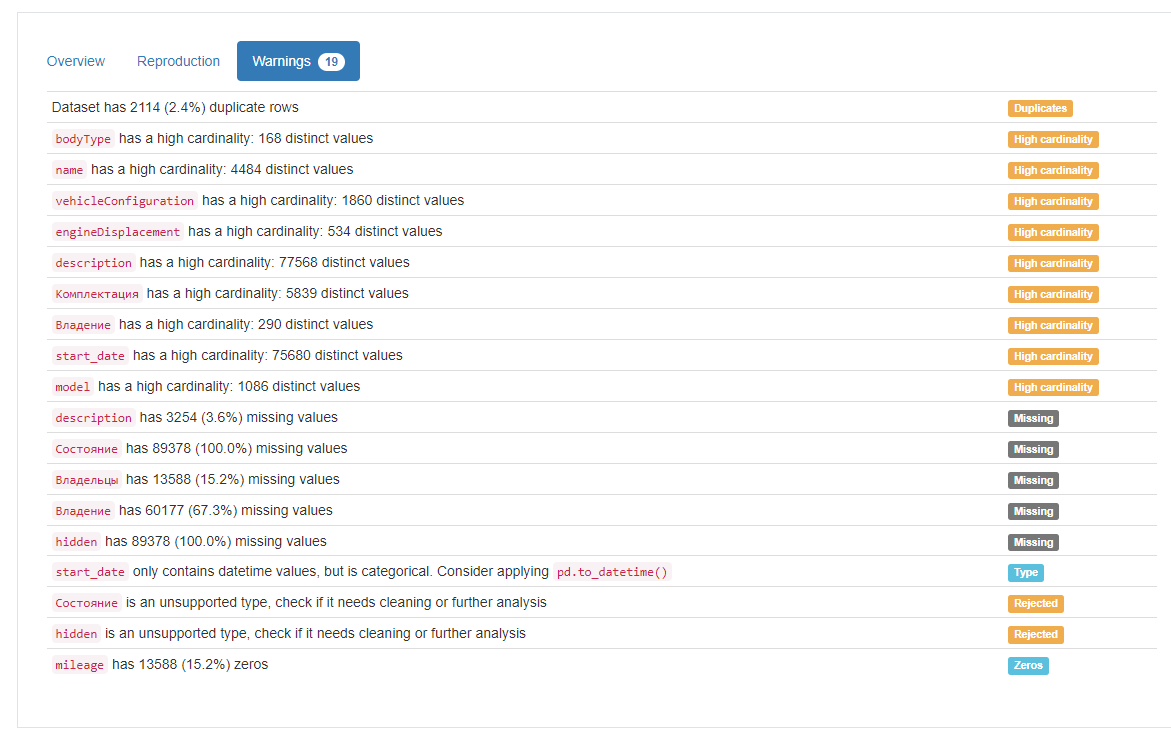

## Data Preprocessing

Видим, что столбец hidden содржит 100% пропусков. 

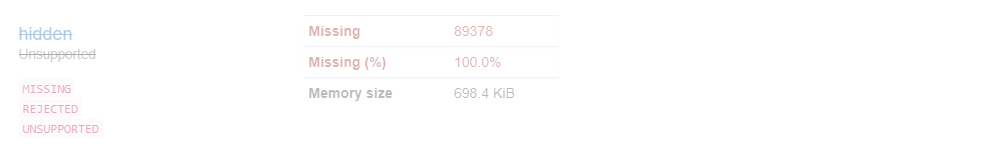

Удалим его

Также как и стоблбец Состояние

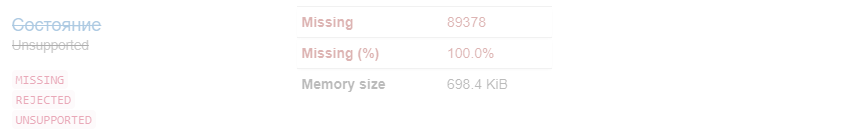

In [193]:
train = train.drop(['hidden','Состояние'], axis=1)

In [194]:
# выведем наглядно число пропусков в трэйне

train.isna().sum().sort_values(ascending=False)

Владение                60177
Владельцы               13588
description              3254
price                     410
ПТС                       361
enginePower                 1
engineDisplacement          1
modelDate                   1
name                        1
numberOfDoors               1
vehicleConfiguration        1
vehicleTransmission         1
bodyType                    1
Привод                      1
start_date                  0
mileage                     0
Комплектация                0
productionDate              0
Руль                        0
Таможня                     0
fuelType                    0
color                       0
brand                       0
model                       0
dtype: int64

Для столбца Владение не указано более 60% значений. Большой процент пропусков. Удалим столбец

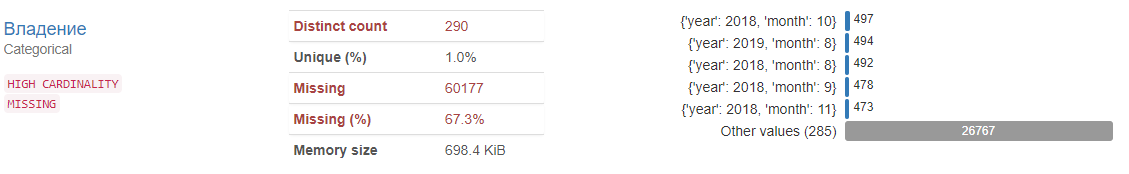

In [195]:
train = train.drop('Владение', axis=1)

В столбце с владельцами также есть пропуски. Вероятно, у этих авто нет зарегистрированных владельцев. Занулим пропуски

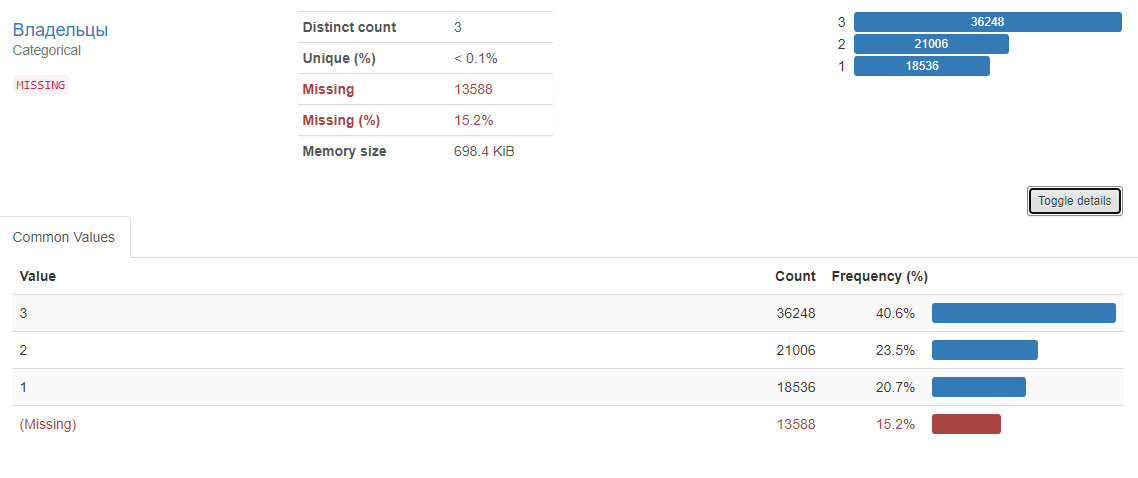

In [196]:
train['Владельцы'] = train['Владельцы'].fillna(0)
train['Владельцы'].isna().sum()

0

Столбец description удалим как в трэйне так и в тесте, т.к. данные в этих столбцах содержат более 90% уникальных значений и это в основном рекламное описание и краткая информация о продавце/салоне

In [197]:
train['description'] = train.drop('description', axis=1)
test['description'] = test.drop('description', axis=1)

В столбце price содержится всего 0.5% пропусков. Удалим эти строки, т.к. цена неизвестна и может только запутать модель

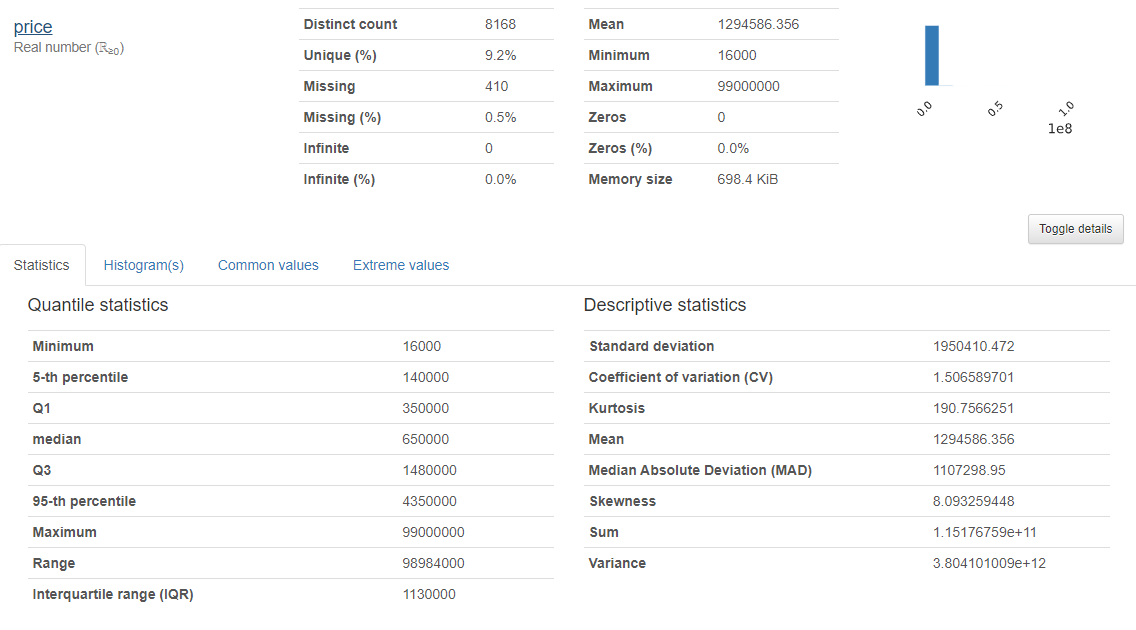

In [198]:
train.dropna(subset=['price'], inplace=True)

ПТС содержит 0,4% пропусков. У нас остаются значения, где число пропусков сведено к 1.
Удалим строки с этими пропусками

In [199]:
train.dropna(subset=['ПТС','enginePower','engineDisplacement','modelDate','name','numberOfDoors',
                     'vehicleConfiguration','vehicleTransmission','bodyType','Привод'], inplace=True)

In [200]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88606 entries, 0 to 89377
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              88606 non-null  object 
 1   brand                 88606 non-null  object 
 2   color                 88606 non-null  object 
 3   fuelType              88606 non-null  object 
 4   modelDate             88606 non-null  float64
 5   name                  88606 non-null  object 
 6   numberOfDoors         88606 non-null  float64
 7   productionDate        88606 non-null  int64  
 8   vehicleConfiguration  88606 non-null  object 
 9   vehicleTransmission   88606 non-null  object 
 10  engineDisplacement    88606 non-null  object 
 11  enginePower           88606 non-null  float64
 12  description           88606 non-null  object 
 13  mileage               88606 non-null  int64  
 14  Комплектация          88606 non-null  object 
 15  Привод             

Избавились от пропусков в трэйне. Проверим пропуски в тесте

In [201]:
test.isna().sum().sort_values(ascending=False)

complectation_dict      28268
Владение                22691
equipment_dict           9996
ПТС                         1
Таможня                     0
enginePower                 0
modelDate                   0
mileage                     0
image                       0
fuelType                    0
description                 0
engineDisplacement          0
model_name                  0
color                       0
car_url                     0
brand                       0
model_info                  0
name                        0
Состояние                   0
numberOfDoors               0
parsing_unixtime            0
priceCurrency               0
productionDate              0
sell_id                     0
super_gen                   0
vehicleConfiguration        0
vehicleTransmission         0
vendor                      0
Владельцы                   0
Привод                      0
Руль                        0
bodyType                    0
dtype: int64

Больше всего пропусков в столбцах 'complectation_dict', 'Владение', 'equipment_dict'.
Мы уже удалили столбце Владение в трэйне из-за отсутствия данных больше половины. В тесте также удалим данный столбец. данные по equipment_dict (оборудованию) отсутствуют в трэйне, также удалим столбец из теста. Для столбца complectation_dict (Комплектация в трэйне) удалим строки с отсутствующими значениями. Также удлаим строку для ПТС (1 пропуск)

In [202]:
test.shape

(34686, 32)

In [203]:
test = test.drop(['Владение','equipment_dict'], axis=1)
#test.dropna(subset=['ПТС','complectation_dict'], inplace=True)

In [204]:
test = test.fillna(0)

In [205]:
test.shape

(34686, 30)

In [206]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    34686 non-null  object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   fuelType              34686 non-null  object
 9   image                 34686 non-null  object
 10  mileage               34686 non-null  int64 
 11  modelDate             34686 non-null  int64 
 12  model_info            34686 non-null  object
 13  model_name            34686 non-null  object
 14  name                  34686 non-null  object
 15  numberOfDoors         34686 non-null

### Стандартизация данных в колонках. 
Проведем приведение к одному виду данных теста и трэйна

#### bodyType

In [207]:
test['body_type'] = [str(x).lower().replace('.', '') for x in test['bodyType']]
train['body_type'] = [str(x).lower() for x in train['bodyType']]

# Заменим длинные типы в train'е на обобщенные значения
body_type_list = list(test['body_type'].unique())
def get_perf_type(x, body_type_list):
    for t in body_type_list:
        if t in x:
            return t
        else: continue
    else: return '0'
    
train['body_type'] = train['body_type'].apply(lambda x: get_perf_type(x, body_type_list))

# Удалим 7 предложений, для которых не нашлось соответствия типа кузова
train = train[train['body_type']!='0']
train.drop(columns=['bodyType'], inplace=True)
test.drop(columns=['bodyType'], inplace=True)

In [208]:
test['body_type'].value_counts()

седан                      13147
внедорожник 5 дв           12228
лифтбек                     2232
хэтчбек 5 дв                2124
универсал 5 дв              1276
минивэн                      995
купе                         824
компактвэн                   489
хэтчбек 3 дв                 485
пикап двойная кабина         280
купе-хардтоп                 158
внедорожник 3 дв             115
родстер                       99
фургон                        97
кабриолет                     90
седан-хардтоп                 12
микровэн                       7
седан 2 дв                     6
лимузин                        6
пикап полуторная кабина        5
пикап одинарная кабина         5
внедорожник открытый           3
тарга                          2
фастбек                        1
Name: body_type, dtype: int64

In [209]:
train['body_type'].value_counts()

внедорожник 5 дв           31829
седан                      31762
хэтчбек 5 дв                9017
универсал 5 дв              3441
лифтбек                     3398
минивэн                     2366
компактвэн                  2074
хэтчбек 3 дв                1760
купе                        1484
пикап двойная кабина         566
внедорожник 3 дв             355
кабриолет                    167
родстер                      151
фургон                       133
пикап полуторная кабина       24
микровэн                      24
внедорожник открытый          17
пикап одинарная кабина        15
тарга                          7
лимузин                        6
фастбек                        3
Name: body_type, dtype: int64

### color

Цвет автомобиля в таблице представлен в разном виде: в test - это названия, а в трэйне цвет закодирован. Приведем к одному виду - к названиям как в test

In [210]:
dict_color = {'040001':'чёрный', 'EE1D19':'красный', '0000CC':'синий', 
              'CACECB':'серебристый', '007F00':'зелёный', 'FAFBFB':'белый', 
              '97948F':'серый', '22A0F8':'голубой', '660099':'пурпурный', 
              '200204':'коричневый', 'C49648':'бежевый', 'DEA522':'золотистый', 
              '4A2197':'фиолетовый', 'FFD600':'жёлтый', 'FF8649':'оранжевый', 
              'FFC0CB':'розовый'}
train['color'] = train['color'].map(dict_color)

### engineDisplacement

В test присутствуют лишние символы  LTR

In [211]:
test['engineDisplacement'] = test['engineDisplacement'].apply(lambda x: str(x).replace('LTR', ''))

Исправим ошибки в трэйне и тесте в engineDisplacement и создадим новые столбцы для объема двигателя и признака гибридности

In [212]:
pattern = re.compile('(\d{1}\.\d{1})')
train['engine'] = train['name'].apply(lambda x:str(pattern.findall(str(x)))[2:5])
train['engine'] = pd.to_numeric(train['engine'], errors='coerce')
train['hybrid'] = train['name'].apply(lambda x: 1 if 'hyb' in x else 0)

In [213]:
pattern = re.compile('(\d{1}\.\d{1})')
test['engine'] = test['name'].apply(lambda x:str(pattern.findall(str(x)))[2:5])
test['engine'] = pd.to_numeric(test['engine'], errors='coerce')
test['hybrid'] = test['name'].apply(lambda x: 1 if 'hyb' in x else 0)

In [214]:
train['engine'].value_counts()

2.0    21193
1.6    18750
3.0     6567
1.8     5993
1.4     5839
       ...  
7.4        1
8.2        1
7.3        1
8.4        1
7.5        1
Name: engine, Length: 68, dtype: int64

In [215]:
test['engine'].value_counts()

2.0    7391
1.6    4973
3.0    3916
1.8    3349
2.5    2477
2.4    1745
3.5    1710
1.4    1635
1.5     725
1.2     485
4.4     447
2.8     384
4.7     377
1.3     365
5.5     361
4.0     356
3.2     348
4.5     346
2.1     271
3.7     242
2.2     236
4.2     228
1.9     221
2.3     203
2.7     189
3.6     183
5.6     170
5.0     158
5.7     135
2.9     130
4.6     108
3.1      88
4.8      84
1.7      59
1.0      57
3.8      57
2.6      55
6.0      53
0.7      53
3.3      44
3.4      36
4.1      35
4.3      32
5.4      31
6.2      28
5.2      12
5.9      12
6.3       8
5.8       7
6.6       6
1.1       4
4.9       4
3.9       1
5.3       1
Name: engine, dtype: int64

In [216]:
train['hybrid'].value_counts()

0    88307
1      292
Name: hybrid, dtype: int64

In [217]:
test['hybrid'].value_counts()

0    34463
1      223
Name: hybrid, dtype: int64

### enginePower

В тестовой выборке к значениям приписано N12, избавимся от лишних символов

In [218]:
test['enginePower'] = test['enginePower'].apply(lambda x: str(x).replace(' N12', '')).astype('float')

### modelDate

поправим формат

In [219]:
train['modelDate'] = train['modelDate'].astype('int')

### vehicleTransmission

поправим соответствие названий

In [220]:
train['vehicleTransmission'] = train['vehicleTransmission'].map({'AUTOMATIC':'автоматическая', 'MECHANICAL':'механическая',
                                                                 'ROBOT':'роботизированная', 'VARIATOR':'вариатор'})

### Владельцы

Обозначим количество владельцев в тренировочной выборке

In [221]:
train['Владельцы'] = train['Владельцы'].map({4.0:'3 или более', 3.0:'3 или более', 2.0:'2 владельца', 1.0:'1 владелец'})

### ПТС

In [222]:
train['ПТС'] = train['ПТС'].map({'ORIGINAL':'Оригинал', 'DUPLICATE':'Дубликат'})

### Руль

In [223]:
train['Руль'] = train['Руль'].map({'RIGHT':'Правый', 'LEFT':'Левый'})

### Таможня

In [224]:
train['Таможня'] = train['Таможня'].map({True: 'Растаможен', False:'Не растаможен'})

In [225]:
train['engineDisplacement'].value_counts()

1.6        16920
2.0        13339
1.4         5625
1.8         5078
2.4         3258
           ...  
Bi-Fuel        1
3.5d           1
SF             1
Easy           1
G5             1
Name: engineDisplacement, Length: 533, dtype: int64

In [226]:
df_train = train
df_test = test 
y = train['price']

## Label Encoding

In [227]:
# переименуем названия колонок в трэйне

df_train = df_train.rename(columns={'model': 'model_name'})

In [228]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет

df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест

In [229]:
data = df_test.append(df_train, sort=False).reset_index(drop=True) 
data

,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,ПТС,Привод,Руль,Состояние,Таможня,body_type,engine,hybrid,sample,Комплектация,price,start_date
0,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,0,лифтбек,1.2,105.0,бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,74000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.2 AMT (105 л.с.),5.0,1.603226e+09,RUB,2014,1.100575e+09,"{""id"":""10373605"",""displacement"":1197,""engine_t...",LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,Оригинал,передний,Левый,Не требует ремонта,Растаможен,лифтбек,1.2,0,0,NaN,NaN,NaN
1,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,0,лифтбек,1.6,110.0,бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,60563,2017,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.6 MT (110 л.с.),5.0,1.603226e+09,RUB,2017,1.100549e+09,"{""id"":""20913311"",""displacement"":1598,""engine_t...",LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,Оригинал,передний,Левый,Не требует ремонта,Растаможен,лифтбек,1.6,0,0,NaN,NaN,NaN
2,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...",лифтбек,1.8,152.0,бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,88000,2013,"{""code"":""SUPERB"",""name"":""Superb"",""ru_name"":""Су...",SUPERB,DSG 1.8 AMT (152 л.с.),5.0,1.603226e+09,RUB,2014,1.100658e+09,"{""id"":""20026323"",""nameplate"":""DSG"",""displaceme...",LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,Оригинал,передний,Левый,Не требует ремонта,Растаможен,лифтбек,1.8,0,0,NaN,NaN,NaN
3,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",лифтбек,1.6,110.0,бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,95000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.6 AT (110 л.с.),5.0,1.603226e+09,RUB,2014,1.100937e+09,"{""id"":""20105521"",""displacement"":1598,""engine_t...",LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,1 владелец,Оригинал,передний,Левый,Не требует ремонта,Растаможен,лифтбек,1.6,0,0,NaN,NaN,NaN
4,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,0,лифтбек,1.8,152.0,бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,58536,2008,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.8 AT (152 л.с.),5.0,1.603226e+09,RUB,2012,1.101038e+09,"{""id"":""4561004"",""displacement"":1798,""engine_ty...",LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,1 владелец,Оригинал,передний,Левый,Не требует ремонта,Растаможен,лифтбек,1.8,0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123280,SSANG_YONG,NaN,чёрный,NaN,Минивэн,2.7d,163.0,дизель,NaN,260000,2004,NaN,RODIUS,2.7d AT (163 л.с.) 4WD,5.0,NaN,NaN,2006,NaN,NaN,MINIVAN AUTOMATIC 2.7d,автоматическая,NaN,3 или более,Оригинал,полный,Левый,NaN,Растаможен,минивэн,2.7,0,1,{'id': '0'},450000.0,2020-02-11T09:29:59Z
123281,SSANG_YONG,NaN,серебристый,NaN,Минивэн,2.7d,163.0,дизель,NaN,300000,2004,NaN,RODIUS,2.7d AT (163 л.с.) 4WD,5.0,NaN,NaN,2007,NaN,NaN,MINIVAN AUTOMATIC 2.7d,автоматическая,NaN,3 или более,Оригинал,полный,Левый,NaN,Растаможен,минивэн,2.7,0,1,{'id': '0'},485000.0,2020-05-30T18:56:30Z
123282,SSANG_YONG,NaN,чёрный,NaN,Минивэн,2.0d,149.0,дизель,NaN,126000,2013,NaN,STAVIC,2.0d AT (149 л.с.) 4WD,5.0,NaN,NaN,2014,NaN,NaN,MINIVAN AUTOMATIC 2.0d,автоматическая,NaN,1 владелец,Оригинал,полный,Левый,NaN,Растаможен,минивэн,2.0,0,1,"{'id': '10408082', 'name': 'Luxury', 'availabl...",1090000.0,2020-08-30T14:39:15Z
123283,SSANG_YONG,NaN,серый,NaN,Минивэн,2.0d,149.0,дизель,NaN,

Удаляем технические столбцы

In [230]:
drop_cols = ['car_url', 'complectation_dict', 'description', 'engineDisplacement', 'image', 'model_info', 
             'name', 'parsing_unixtime', 'priceCurrency', 'sell_id', 'super_gen', 'vehicleConfiguration', 
             'Состояние', 'Таможня', 'Комплектация', 'start_date', 'vendor']
data.drop(columns=drop_cols, inplace=True)

In [231]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123285 entries, 0 to 123284
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   brand                123285 non-null  object 
 1   color                123285 non-null  object 
 2   enginePower          123285 non-null  float64
 3   fuelType             123285 non-null  object 
 4   mileage              123285 non-null  int64  
 5   modelDate            123285 non-null  int64  
 6   model_name           123285 non-null  object 
 7   numberOfDoors        123285 non-null  float64
 8   productionDate       123285 non-null  int64  
 9   vehicleTransmission  123285 non-null  object 
 10  Владельцы            110077 non-null  object 
 11  ПТС                  123285 non-null  object 
 12  Привод               123285 non-null  object 
 13  Руль                 123285 non-null  object 
 14  body_type            123285 non-null  object 
 15  engine           

In [232]:
data

,brand,color,enginePower,fuelType,mileage,modelDate,model_name,numberOfDoors,productionDate,vehicleTransmission,Владельцы,ПТС,Привод,Руль,body_type,engine,hybrid,sample,price
0,SKODA,синий,105.0,бензин,74000,2013,OCTAVIA,5.0,2014,роботизированная,3 или более,Оригинал,передний,Левый,лифтбек,1.2,0,0,NaN
1,SKODA,чёрный,110.0,бензин,60563,2017,OCTAVIA,5.0,2017,механическая,1 владелец,Оригинал,передний,Левый,лифтбек,1.6,0,0,NaN
2,SKODA,серый,152.0,бензин,88000,2013,SUPERB,5.0,2014,роботизированная,1 владелец,Оригинал,передний,Левый,лифтбек,1.8,0,0,NaN
3,SKODA,коричневый,110.0,бензин,95000,2013,OCTAVIA,5.0,2014,автоматическая,1 владелец,Оригинал,передний,Левый,лифтбек,1.6,0,0,NaN
4,SKODA,белый,152.0,бензин,58536,2008,OCTAVIA,5.0,2012,автоматическая,1 владелец,Оригинал,передний,Левый,лифтбек,1.8,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123280,SSANG_YONG,чёрный,163.0,дизель,260000,2004,RODIUS,5.0,2006,автоматическая,3 или более,Оригинал,полный,Левый,минивэн,2.7,0,1,450000.0
123281,SSANG_YONG,серебристый,163.0,дизель,300000,2004,RODIUS,5.0,2007,автоматическая,3 или более,Оригинал,полный,Левый,минивэн,2.7,0,1,485000.0
123282,SSANG_YONG,чёрный,149.0,дизель,126000,2013,STAVIC,5.0,2014,автоматическая,1 владелец,Оригинал,полный,Левый,минивэн,2.0,0,1,1090000.0
123283,SSANG_YONG,серый,149.0,дизель,84000,2013,STAVIC,5.0,2013,автоматическая,3 или более,Оригинал,полный,Левый,минивэн,2.0,0,1,1180000.0


In [233]:
# заполняем оставшиеся пропуски после объединения

data = data.fillna(0)
data.isna().sum()

brand                  0
color                  0
enginePower            0
fuelType               0
mileage                0
modelDate              0
model_name             0
numberOfDoors          0
productionDate         0
vehicleTransmission    0
Владельцы              0
ПТС                    0
Привод                 0
Руль                   0
body_type              0
engine                 0
hybrid                 0
sample                 0
price                  0
dtype: int64

### Объединим признаки по типам

In [234]:
# Полученные признаки сгруппируем в две категории по типу их обработки

# числовые переменные
# исключим из списка переменные price и sample. 'hybrid','numberOfDoors'  - это категориальные
num_cols = data.select_dtypes(include='number').columns.drop(['price','sample','hybrid','numberOfDoors'])
print('num_cols =', len(num_cols))


# категориальные переменные
#cat_cols = data.select_dtypes(exclude='number').columns
#cat_cols = pd.Series(np.concatenate((cat_cols.values, ['hybrid'])))

cat_cols = data.drop(num_cols, axis=1)
cat_cols = cat_cols.drop(['price','sample'], axis=1)
print('cat_cols =', len(cat_cols))


target_cols = data['price']

num_cols = 5
cat_cols = 123285


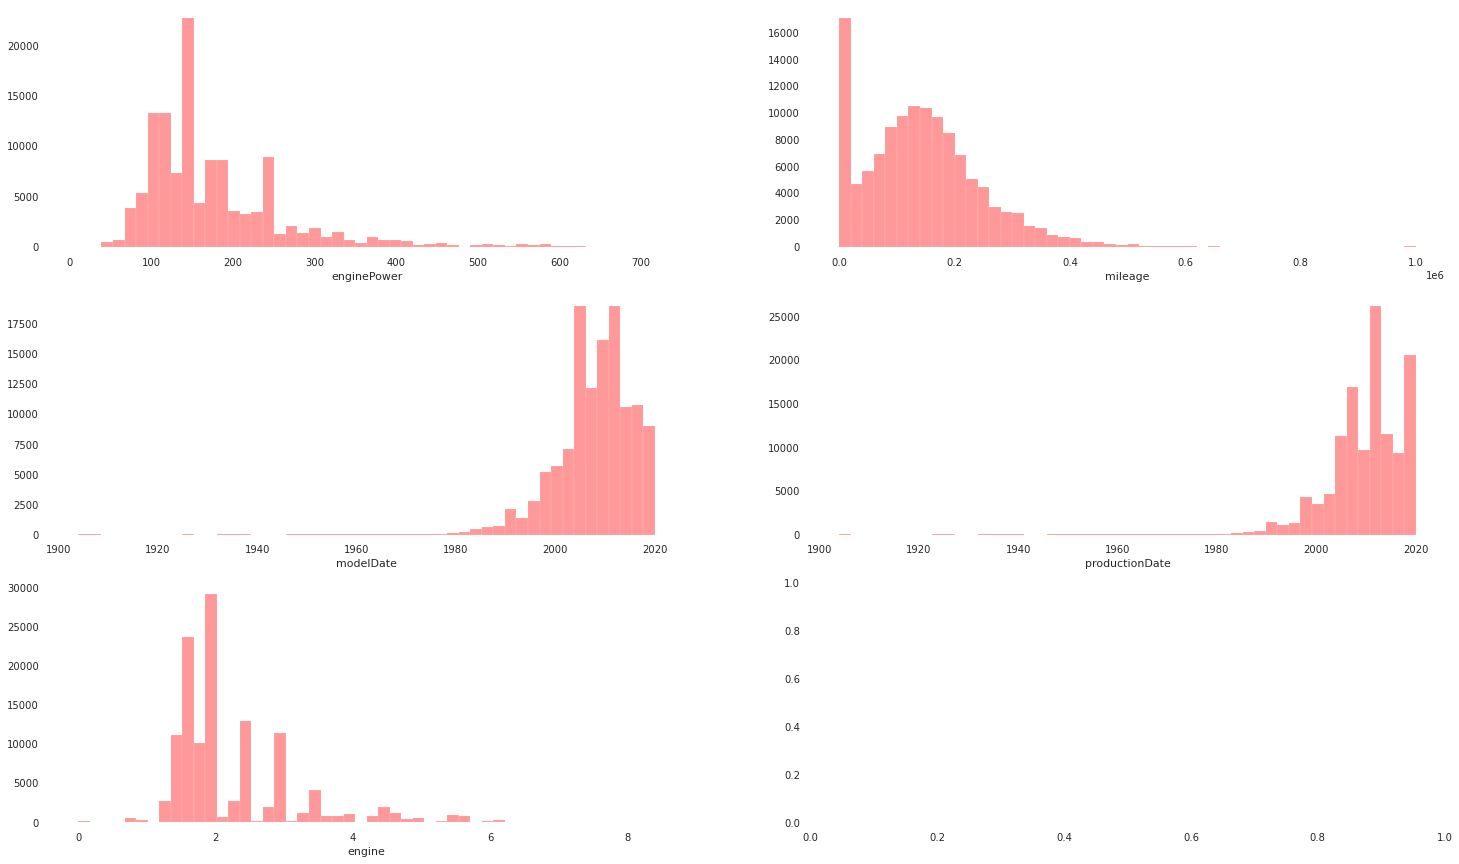

In [235]:
# посмотрим на распределение числовых данных

fig, axes = plt.subplots(3, 2, figsize=(25,15))

for i,col in enumerate(num_cols):
    sns.distplot(data[col], kde=False, ax=axes.flat[i], color="r")

Распределения близки к нормальному. Лучше всего это видно на столбце mileage, однако у всех довольно большой разброс значений.

###  Определяем значимость числовых переменных

Для оценки значимости числовых переменных будем использовать функцию f_classif из библиотеки sklearn. В качестве меры значимости мы будем использовать значение f-статистики. Чем значение статистики выше, тем меньше вероятность того, что средние значения не отличаются, и тем важнее данный признак для нашей линейной модели.

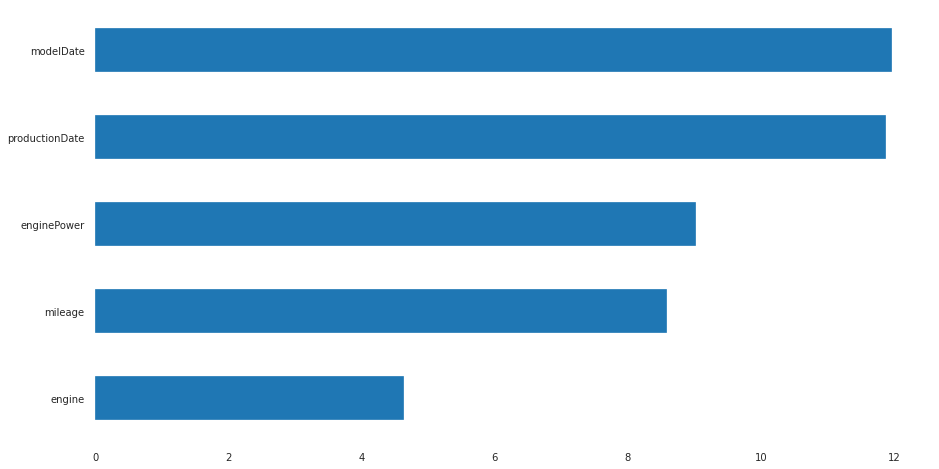

In [236]:
imp_num = pd.Series(f_classif(data[num_cols], target_cols)[0], index = num_cols)
imp_num.sort_values(inplace = True)
plt.rcParams['font.size'] = '18'
imp_num.plot(kind = 'barh', figsize=(15,8))

Судя по графику наибольшее влияние оказывают данные с выпуском модели и датой производства

### Обработка категориальных переменных

все категориальные признаки должны быть численными.
Это важно для дальнейшего определения значимости категориальных переменных с использованием mutual_info_classif

In [237]:
cat_cols

,brand,color,fuelType,model_name,numberOfDoors,vehicleTransmission,Владельцы,ПТС,Привод,Руль,body_type,hybrid
0,SKODA,синий,бензин,OCTAVIA,5.0,роботизированная,3 или более,Оригинал,передний,Левый,лифтбек,0
1,SKODA,чёрный,бензин,OCTAVIA,5.0,механическая,1 владелец,Оригинал,передний,Левый,лифтбек,0
2,SKODA,серый,бензин,SUPERB,5.0,роботизированная,1 владелец,Оригинал,передний,Левый,лифтбек,0
3,SKODA,коричневый,бензин,OCTAVIA,5.0,автоматическая,1 владелец,Оригинал,передний,Левый,лифтбек,0
4,SKODA,белый,бензин,OCTAVIA,5.0,автоматическая,1 владелец,Оригинал,передний,Левый,лифтбек,0
...,...,...,...,...,...,...,...,...,...,...,...,...
123280,SSANG_YONG,чёрный,дизель,RODIUS,5.0,автоматическая,3 или более,Оригинал,полный,Левый,минивэн,0
123281,SSANG_YONG,серебристый,дизель,RODIUS,5.0,автоматическая,3 или более,Оригинал,полный,Левый,минивэн,0
123282,SSANG_YONG,чёрный,дизель,STAVIC,5.0,автоматическая,1 владелец,Оригинал,полный,Левый,минивэн,0
123283,SSANG_YONG,серый,дизель,STAVIC,5.0,автоматическая,3 или более,Оригинал,полный,Левый,минивэн,0


Закодируем категориальные переменные 

In [238]:
for column in cat_cols:
    data[column] = data[column].astype('category').cat.codes
display(data.head())

,brand,color,enginePower,fuelType,mileage,modelDate,model_name,numberOfDoors,productionDate,vehicleTransmission,Владельцы,ПТС,Привод,Руль,body_type,engine,hybrid,sample,price
0,29,13,105.0,0,74000,2013,684,4,2014,3,5,2,1,0,8,1.2,0,0,0.0
1,29,15,110.0,0,60563,2017,684,4,2017,2,2,2,1,0,8,1.6,0,0,0.0
2,29,12,152.0,0,88000,2013,919,4,2014,3,2,2,1,0,8,1.8,0,0,0.0
3,29,6,110.0,0,95000,2013,684,4,2014,0,2,2,1,0,8,1.6,0,0,0.0
4,29,1,152.0,0,58536,2008,684,4,2012,0,2,2,1,0,8,1.8,0,0,0.0


In [239]:
#train.dropna(subset=['productionDate','mileage'], inplace=True)
#train.dropna(subset=['price'], inplace=True)

In [240]:
# для baseline просто возьму пару схожих признаков без полной обработки
#columns = ['bodyType', 'brand', 'productionDate', 'engineDisplacement', 'mileage']
#df_train = train[columns]
#df_test = test[columns]

In [241]:
#y = train['price']

## Label Encoding

In [242]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
#df_train['sample'] = 1 # помечаем где у нас трейн
#df_test['sample'] = 0 # помечаем где у нас тест

#data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [243]:
#for colum in ['bodyType', 'brand', 'engineDisplacement']:
#    data[colum] = data[colum].astype('category').cat.codes

In [244]:
data

,brand,color,enginePower,fuelType,mileage,modelDate,model_name,numberOfDoors,productionDate,vehicleTransmission,Владельцы,ПТС,Привод,Руль,body_type,engine,hybrid,sample,price
0,29,13,105.0,0,74000,2013,684,4,2014,3,5,2,1,0,8,1.2,0,0,0.0
1,29,15,110.0,0,60563,2017,684,4,2017,2,2,2,1,0,8,1.6,0,0,0.0
2,29,12,152.0,0,88000,2013,919,4,2014,3,2,2,1,0,8,1.8,0,0,0.0
3,29,6,110.0,0,95000,2013,684,4,2014,0,2,2,1,0,8,1.6,0,0,0.0
4,29,1,152.0,0,58536,2008,684,4,2012,0,2,2,1,0,8,1.8,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123280,30,15,163.0,3,260000,2004,806,4,2006,0,5,2,2,0,10,2.7,0,1,450000.0
123281,30,11,163.0,3,300000,2004,806,4,2007,0,5,2,2,0,10,2.7,0,1,485000.0
123282,30,15,149.0,3,126000,2013,909,4,2014,0,1,2,2,0,10,2.0,0,1,1090000.0
123283,30,12,149.0,3,84000,2013,909,4,2013,0,5,2,2,0,10,2.0,0,1,1180000.0


In [245]:
X = data.query('sample == 1').drop(['sample', 'price'], axis=1)
X_sub = data.query('sample == 0').drop(['sample', 'price'], axis=1)
y = data.query('sample == 1')['price'] 

In [246]:
X_sub.shape

(34686, 17)

In [247]:
X.shape

(88599, 17)

## Train Split

In [248]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

In [249]:
X_test

,brand,color,enginePower,fuelType,mileage,modelDate,model_name,numberOfDoors,productionDate,vehicleTransmission,Владельцы,ПТС,Привод,Руль,body_type,engine,hybrid
98413,32,15,92.0,0,168453,2004,923,4,2007,0,1,2,1,1,23,1.3,0
86041,25,1,184.0,3,139000,2010,120,4,2012,0,5,2,2,0,1,2.2,0
90326,26,11,120.0,0,40400,2012,53,3,2016,0,1,2,1,0,15,1.6,0
81053,24,15,175.0,0,138000,2006,114,1,2007,1,5,2,1,0,5,2.5,0
92232,28,7,143.0,0,10465,2016,549,4,2018,0,1,2,2,0,1,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110316,34,12,105.0,0,205000,2010,959,4,2012,2,3,2,1,0,4,1.2,0
86683,25,11,90.0,3,290000,2006,129,4,2010,2,3,2,1,0,19,1.3,0
37224,0,1,245.0,3,180000,2010,92,4,2011,3,5,1,2,0,8,3.0,0
71457,17,12,200.0,3,85000,2014,886,4,2017,0,5,2,2,0,1,2.2,0


# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели двигателя (engineDisplacement). 
C ней будем сравнивать другие модели.




In [250]:
tmp_train = X_train.copy()
tmp_train['price'] = y_train

In [251]:
# Находим median по экземплярам engineDisplacement в трейне и размечаем тест
predict = X_test['engine'].map(tmp_train.groupby('engine')['price'].median())

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict.values))*100:0.2f}%")

# Точность наивной модели по метрике MAPE: 102.08%

Точность наивной модели по метрике MAPE: 89.68%


# # Model 2 : CatBoost
![](https://pbs.twimg.com/media/DP-jUCyXcAArRTo.png:large)   


У нас в данных практически все признаки категориальные. Специально для работы с такими данными была создана очень удобная библиотека CatBoost от Яндекса. [https://catboost.ai](http://)     
На данный момент **CatBoost является одной из лучших библиотек для табличных данных!**

#### Полезные видео о CatBoost (на русском):
* [Доклад про CatBoost](https://youtu.be/9ZrfErvm97M)
* [Свежий Туториал от команды CatBoost (практическая часть)](https://youtu.be/wQt4kgAOgV0) 

## Fit

In [252]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, y_train,
         #cat_features=cat_features_ids,
         eval_set=(X_test, y_test),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

model.save_model('catboost_single_model_baseline.model')

In [253]:
# оцениваем точность
predict = model.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели по метрике MAPE: 14.67%


Получаем точность модели по метрике MAPE: 14.19%

### Log Traget
Попробуем взять таргет в логорифм - это позволит уменьшить влияние выбросов на обучение модели (используем для этого np.log и np.exp).    
в дату сбора данных, смотрим дату парсинга в тесте в **parsing_unixtime**

In [254]:
np.log(y_train)

83266     13.790193
90362     12.873902
42531     13.500800
105328    14.326236
114137    14.790070
            ...    
40951     14.430696
89572     12.154779
111506    13.987782
35546     13.296317
50481     12.128111
Name: price, Length: 70879, dtype: float64

In [255]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, np.log(y_train),
         #cat_features=cat_features_ids,
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

model.save_model('catboost_single_model_2_baseline.model')

In [256]:
predict_test = np.exp(model.predict(X_test))
predict_submission = np.exp(model.predict(X_sub))

In [257]:
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

#Точность модели по метрике MAPE: 12.14%

Точность модели по метрике MAPE: 12.28%


## Random Forest

In [258]:
# Зададим сетку гиперпараметров

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 300, num = 3)]
max_features = ['auto', 'sqrt']
#max_depth = [int(x) for x in np.linspace(10, 20, num = 11)]
max_depth = [int(x) for x in np.linspace(5, 15, num = 6)] + [None]
#max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [259]:
# обучим лес

rf = RandomForestRegressor(random_state=RANDOM_SEED)

rf_random = RandomizedSearchCV(estimator=rf, 
                               param_distributions=random_grid, 
                               n_iter=100, 
                               cv=3, 
                               verbose=10, 
                               random_state=RANDOM_SEED, 
                               n_jobs=-1)
rf_random.fit(X_train, np.log(y_train))

# время обучения около 40 минут

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 18.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 21.9min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 24

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 7, 9, 11, 13, 15,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42, verbose=10)

In [260]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

In [261]:
# заносим найденные ранее best parameters в переменную
best_rf = {'n_estimators': 200,
           'min_samples_split': 5,
           'min_samples_leaf': 2,
           'max_features': 'sqrt',
           'max_depth': None,
           'bootstrap': False}

In [262]:
predict_test = np.exp(rf_random.predict(X_test))
#predict_submission = np.exp(rf_random.predict(X_sub))

print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

#Точность модели по метрике MAPE: 12.36%. Результат явно хуже

Точность модели по метрике MAPE: 12.41%


In [263]:
# Обучим модель на best parameters 

rf_opt = RandomForestRegressor(random_state=RANDOM_SEED).set_params(**best_rf)

rf_opt.fit(X_train, np.log(y_train))

RandomForestRegressor(bootstrap=False, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=200, random_state=42)

In [264]:
# находим предикт

y_pred_opt = rf_opt.predict(X_test)
#predict_submission = np.exp(rf_opt.predict(X_sub))

print(f"Точность модели по метрике MAPE: {(mape(y_test, y_pred_opt))*100:0.2f}%")

Точность модели по метрике MAPE: 100.00%


## Линейная регрессия

In [265]:
# отдельно нормализуем отобранные признаки для тестовой и для обучающей выборки
# для этого применяем функцию RobustScaler() (не чувствительна к выбросам)
# для использования RobustScaler() подключаем библиотеку

from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

X_train_trans = scaler.fit_transform(X_train)
X_test_trans = scaler.transform(X_test)

# Обучаем модель на нормализованных данных для обучения (X_train_trans)

from sklearn.linear_model import LinearRegression

lr_model = LinearRegression() #Обозначаем, что наша модель - линейная регрессия
lr_model = lr_model.fit(X_train_trans,y_train) #обучаем модель на обучающих данных

# предсказываем значения зависимой переменной для тестовой выборки:
# используем нормализованную тестовую выборку (X_test_trans)

y_pred_lr = lr_model.predict(X_test_trans)
print(f"Точность модели по метрике MAPE: {(mape(y_test, y_pred_lr))*100:0.2f}%")

Точность модели по метрике MAPE: 124.78%


## Градиентный бустинг. GradientBoostingClassifier

In [266]:
'''# estimator: обучаем модель градиентного бустинга:
# в модели градиентного бустинга параметр max_depth вообще не указываем

clf = GradientBoostingClassifier(learning_rate=0.01, 
                                 n_estimators=1250, 
                                 random_state=RANDOM_SEED)
clf.fit(X_train, y_train)


# воспользуемся GridSearchCV для подбора максимальной глубины (max_depth)
# В качестве estimator используем градиентный бустинг 
# Переберем все значения max_depth от 5 до 15 включительно

param_grid = {'max_depth':[5,10,15]}

gscv = GridSearchCV(clf, param_grid, scoring = 'neg_mean_absolute_error', n_jobs=-1, cv=5)
gscv.fit(X_train, y_train)

y_pred = gscv.predict(X_test)


# выводим лучший результат точности и параметра глубины max_depth

print(gscv.best_score_)
gscv.best_params_'''
# модель на градиентном бустинге GradientBoostingClassifier не обучается

"# estimator: обучаем модель градиентного бустинга:\n# в модели градиентного бустинга параметр max_depth вообще не указываем\n\nclf = GradientBoostingClassifier(learning_rate=0.01, \n                                 n_estimators=1250, \n                                 random_state=RANDOM_SEED)\nclf.fit(X_train, y_train)\n\n\n# воспользуемся GridSearchCV для подбора максимальной глубины (max_depth)\n# В качестве estimator используем градиентный бустинг \n# Переберем все значения max_depth от 5 до 15 включительно\n\nparam_grid = {'max_depth':[5,10,15]}\n\ngscv = GridSearchCV(clf, param_grid, scoring = 'neg_mean_absolute_error', n_jobs=-1, cv=5)\ngscv.fit(X_train, y_train)\n\ny_pred = gscv.predict(X_test)\n\n\n# выводим лучший результат точности и параметра глубины max_depth\n\nprint(gscv.best_score_)\ngscv.best_params_"

## Gradient Boosting Regressor

In [267]:
from sklearn.ensemble import GradientBoostingRegressor

random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 400, num = 8)],
               'max_features': ['auto', 'sqrt', 'log2'],
               'max_depth': [int(x) for x in np.linspace(5, 15, num = 6)] + [None],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4]}

gbr = GradientBoostingRegressor()
gbr_random = RandomizedSearchCV(estimator = gbr, 
                                param_distributions = random_grid, 
                                n_iter = 100, cv = 3, 
                                verbose=10, 
                                random_state=RANDOM_SEED, 
                                n_jobs = -1)
gbr_random.fit(X_train, np.log(y_train))
gbr_random.best_params_
best_gbr = GradientBoostingRegressor(random_state=RANDOM_SEED, 
                                     n_estimators=800, 
                                     min_samples_split=5, 
                                     min_samples_leaf=4, 
                                     max_features='sqrt', 
                                     max_depth=9)
best_gbr.fit(X_train, np.log(y_train))

predict_gbr = np.exp(best_gbr.predict(X_test))

# длительность выполнения 67 минут

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 20.4min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 22.9min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 25.6min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 26.7min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 30.1min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 33.0min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 37.3min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 41

In [268]:
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_gbr))*100:0.2f}%")

# Точность модели по метрике MAPE: 12.24%. Уже лучше, но явно хуже с первым опытом

Точность модели по метрике MAPE: 12.34%


## Бэггинг с xgb

In [269]:
import xgboost as xgb
from sklearn.ensemble import BaggingRegressor

xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', 
                           colsample_bytree=0.5,
                           learning_rate=0.05, 
                           max_depth=12, 
                           alpha=1,
                           n_estimators=1000)

bagg_xgb = BaggingRegressor(xgb_reg, n_estimators=3, n_jobs=1, random_state=RANDOM_SEED)
bagg_xgb.fit(X_train, np.log(y_train))
predict_bagg_xgb = np.exp(bagg_xgb.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_bagg_xgb))*100:0.2f}%")

#Точность модели по метрике MAPE: 11.88%

Точность модели по метрике MAPE: 12.03%


## Стеккинг

In [270]:
from sklearn.ensemble import StackingRegressor

estimators=[('b_gbr', BaggingRegressor(GradientBoostingRegressor(random_state=RANDOM_SEED,
                                                                 n_estimators=800,
                                                                 min_samples_split=5,
                                                                 min_samples_leaf=4,
                                                                 max_features='sqrt',
                                                                 max_depth=9),
                                       n_estimators=3,
                                       n_jobs=1,
                                       random_state=RANDOM_SEED))
            ,('xgb', xgb.XGBRegressor(objective='reg:squarederror',
                                      colsample_bytree=0.5,
                                      learning_rate=0.05,
                                      max_depth=12,
                                      alpha=1,
                                      n_estimators=1000))]

st_ensemble = StackingRegressor(estimators=estimators
                                ,final_estimator = CatBoostRegressor(iterations = 5000,
                                                                     random_seed = RANDOM_SEED,
                                                                     eval_metric='MAPE',
                                                                     custom_metric=['R2', 'MAE'],
                                                                     silent=True
                                                                     #,learning_rate=0.13
                                                                     #,depth=12
                                                                     #,l2_leaf_reg=8
                                                                     #,random_strength=0.3
                                                                    ))

    
st_ensemble.fit(X_train, np.log(y_train))

predict_ensemble = np.exp(st_ensemble.predict(X_test))

In [271]:
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_ensemble))*100:0.2f}%")

#Точность модели по метрике MAPE: 12.03%

Точность модели по метрике MAPE: 12.18%


In [272]:
# стекинг

from sklearn.ensemble import StackingRegressor

estimators2=[('b_gbr', GradientBoostingRegressor(random_state=RANDOM_SEED,
                                                                 n_estimators=800,
                                                                 min_samples_split=5,
                                                                 min_samples_leaf=4,
                                                                 max_features='sqrt',
                                                                 max_depth=9))
 #                                      n_estimators=3,
  #                                     n_jobs=1,
   #                                    random_state=RANDOM_SEED))
            ,('rfr', RandomForestRegressor(random_state=RANDOM_SEED).set_params(**best_rf))]


st_ensemble2 = StackingRegressor(estimators=estimators2,
                                final_estimator = CatBoostRegressor(iterations = 5000,
                                                                     random_seed = RANDOM_SEED,
                                                                     eval_metric='MAPE',
                                                                     custom_metric=['R2', 'MAE'],
                                                                     silent=True
                                                                     #,learning_rate=0.13
                                                                     #,depth=12
                                                                     #,l2_leaf_reg=8
                                                                     #,random_strength=0.3
                                                                   ))
st_ensemble2.fit(X_train, np.log(y_train))

predict_ensemble2 = np.exp(st_ensemble2.predict(X_test))

In [273]:
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_ensemble2))*100:0.2f}%")

#Точность модели по метрике MAPE: 12.21%

Точность модели по метрике MAPE: 12.27%


In [274]:
# попробуем объединить все ансамбли

estimators3=[('b_gbr', BaggingRegressor(GradientBoostingRegressor(random_state=RANDOM_SEED,
                                                                 n_estimators=800,
                                                                 min_samples_split=5,
                                                                 min_samples_leaf=4,
                                                                 max_features='sqrt',
                                                                 max_depth=9),
                                       n_estimators=3,
                                       n_jobs=1,
                                       random_state=RANDOM_SEED))
            ,('xgb', xgb.XGBRegressor(objective='reg:squarederror',
                                      colsample_bytree=0.5,
                                      learning_rate=0.05,
                                      max_depth=12,
                                      alpha=1,
                                      n_estimators=1000)),
           ('rfr', RandomForestRegressor(random_state=RANDOM_SEED).set_params(**best_rf))]

st_ensemble3 = StackingRegressor(estimators=estimators3,
                                 final_estimator = CatBoostRegressor(iterations = 5000,
                                                                     random_seed = RANDOM_SEED,
                                                                     eval_metric='MAPE',
                                                                     custom_metric=['R2', 'MAE'],
                                                                     silent=True
                                                                     #,learning_rate=0.13
                                                                     #,depth=12
                                                                     #,l2_leaf_reg=8
                                                                     #,random_strength=0.3
                                                                    ))

    
st_ensemble3.fit(X_train, np.log(y_train))

predict_ensemble3 = np.exp(st_ensemble3.predict(X_test))

In [275]:
predict_ensemble3 = np.exp(st_ensemble3.predict(X_test))

In [276]:
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_ensemble3))*100:0.2f}%")

#Точность модели по метрике MAPE: 11.98%

Точность модели по метрике MAPE: 12.18%


Точность модели по метрике MAPE: 12.14% при стандартной обработке

# Submission

In [282]:
len(sample_submission)

34686

In [284]:
#predict_submission = np.exp(model.predict(X_sub))
predict_submission = np.round(np.exp(st_ensemble3.predict(X_sub)),-3)
predict_submission 

array([ 593000.,  895000.,  862000., ...,  186000., 1108000., 1035000.])

In [283]:
len(predict_submission)

34686

In [285]:
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_2_v{VERSION}.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1100575026,593000.0
1,1100549428,895000.0
2,1100658222,862000.0
3,1100937408,691000.0
4,1101037972,719000.0
5,1100912634,761000.0
6,1101228730,591000.0
7,1100165896,394000.0
8,1100768262,1697000.0
9,1101218501,789000.0


В итоге получили **MAPE 27%** на ЛБ!

Большая разница в ошибке может указывать на то что тест и трейн имеют различия по выборке или то что данные в трейне могли уже устареть и их нужно обновлять.

# What's next?
Или что еще можно сделать, чтоб улучшить результат:

* Спарсить свежие данные 
* Посмотреть, что можно извлечь из признаков или как еще можно обработать признаки
* Сгенерировать новые признаки
* Попробовать подобрать параметры модели
* Попробовать другие алгоритмы и библиотеки ML
* Сделать Ансамбль моделей, Blending, Stacking

Подробный чек лист: https://docs.google.com/spreadsheets/d/1I_ErM3U0Cs7Rs1obyZbIEGtVn-H47pHNCi4xdDgUmXY/edit?usp=sharing